# **Bifurcation Analysis of a Temperature Inversion Strength Model**


$\frac{\Delta T}{dt} = Q_i - \lambda \Delta T - \rho c_p \left( \frac{k}{\log\frac{z_r}{z_0}}\right)^2 U \Delta T f(\Delta T)$

The model for temperature inversion strength will be analysed for three different stability functions $f$.

In the following, the temperature inversion strength $\Delta T$ is denoted as $x$.

In [1]:

import PyDSTool as dst
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

### System specification

In [2]:
# name of the model
'''‘args’ class imported from PyDSTool, essentially a structure that collects together data attributes in an 
addressable way. use it here to build all the information needed to create a valid dynamical system mode'''
DSargs = dst.args(name='temperature inversion strength model') 

# parameters of Data from Cabauw
DSargs.pars = { 'q': 70,        # isothermal net radiation
                'l': 4,         # lumped parameter
                'U': 8.9,      # wind speed
                'rho': 1.2,     # air density
                'c_p': 1005,    # heat capacity of air
                'k': 0.4,       # Kármán constant
                'g': 9.81,      # gravitational constant
                'T_r': 285,     # temparature in reference height
                'z_r': 40,      # reference height
                'z_0': 0.03,    # temperature measure point above surface
                'alpha': 5}     

'''Stability functions: 
cut_off: 'if(x < pow(U,2) * T_r / (2 * alpha * z_r * g), 1 - 2 * alpha * z_r * g/T_r * x/pow(U,2), 0)'
long-tail: 'exp(-2 * alpha * z_r * g/T_r * x/pow(U,2))'
short-tail: 'exp(-2 * alpha * z_r * g/T_r * x/pow(U,2) - pow((alpha * z_r * g/T_r * x/pow(U,2)),2))'
'''
DSargs.fnspecs  = {'f': (['x'], 'exp(-2 * alpha * z_r * g/T_r * x/pow(U,2) - pow((alpha * z_r * g/T_r * x/pow(U,2)),2))') } 
# rhs of the differential equation, including dummy variable w
DSargs.varspecs = {'x': 'q - l*x - rho * c_p * pow((k/log(z_r/z_0)),2) * U * x * f(x)',   
                   'w': 'x-w' }
# initial conditions
DSargs.ics      = {'x': 5, 'w': 5}

'w' is a dummy variable which is necessary to permit the 2-parameter continuation of the limit points later on which otherwise cannot be done for a 1D dynamical system. It only tracks x.

### **Integral curves**
Computaion of the trajectories of the differential equation by using a Generator instance.

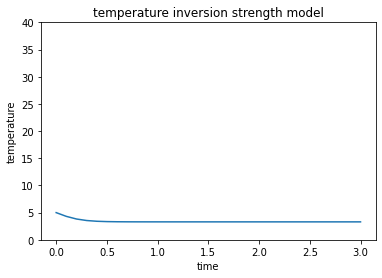

In [3]:
DSargs.tdomain = [0,3]                          # set the range of integration.
ode  = dst.Generator.Vode_ODEsystem(DSargs)     # an instance of the 'Generator' class.
traj = ode.compute('inversion')                # integrate ODE
pts  = traj.sample(dt=0.1)                      # Data for plotting

# PyPlot commands
plt.plot(pts['t'], pts['x'])
plt.xlabel('time')                              # Axes labels
plt.ylabel('temperature')                       # ...
plt.ylim([0,40])                                # Range of the y axis
plt.title(ode.name)                             # Figure title from model name
plt.show()

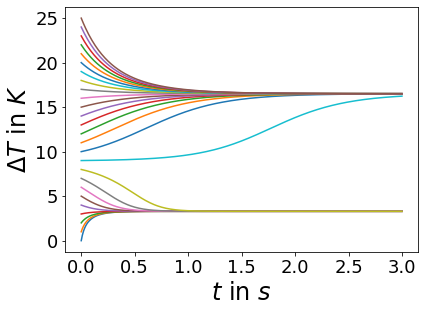

In [4]:
fig = plt.figure(figsize=(7,5))
plt.clf()                                        # Clear the figure
#plt.hold(True)                                  # Sequences of plot commands will not clear the existing figure, 
                                                 # depends on python-version whether this command is necessary
for i, x0 in enumerate(np.linspace(0,25,26)):    # interval of initial temperature values and number of solution curves
    ode.set( ics = { 'x': x0 } )                # Initial condition
    # Trajectories are called inv0, inv1, ...
    # sample them on the fly to create Pointset tmp
    tmp = ode.compute('pol%3i' % i).sample()    # or specify dt option to sample to sub-sample
    plt.plot(tmp['t'], tmp['x'])
plt.xlabel('$t$ in $s$', fontsize = 24)
plt.ylabel('$\Delta T$ in $K$', fontsize = 24)
plt.title('')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(axis="x", nbins=8)
plt.locator_params(axis="y", nbins=8)
plt.gcf().subplots_adjust(left=0.2, bottom =0.2)
plt.savefig('multiple_ics.png')
plt.show()

Several solution curves of varying initial temperature differences. For a small lumped parameter $\lambda$ = 4 Wm⁻²K⁻¹ and a wind speed U = 8.9 ms⁻¹, three equilibria can be observed: Two stable equilibria, towards which solutions with close initial conditions move over time and, between them, one unstable equilibrium where solutions quickly move away over time.

### **Bifurcation Diagram**

In [5]:
# Prepare the system to start close to a steady state
ode.set(pars = {'U': 0.01} )           # Lower bound of the control parameter 'U'
ode.set(ics =  {'x': 1.3} )       # Close to one of the steady states present for i=-220

PC = dst.ContClass(ode)               # Set up continuation class

PCargs = dst.args(name='EQ1', type='EP-C')     # 'EP-C' stands for Equilibrium Point Curve. The branch will be labeled 'EQ1'.
PCargs.freepars     = ['U']                    # control parameter(s) (it should be among those specified in DSargs.pars)
PCargs.MaxNumPoints = 64                       # The following 3 parameters are set after trial-and-error
PCargs.MaxStepSize  = 1
PCargs.MinStepSize  = 1e-5
PCargs.StepSize     = 2e-2
PCargs.LocBifPoints = 'LP'                     # detect limit points / saddle-node bifurcations
PCargs.SaveEigen    = True                     # to tell unstable from stable branches

LP Point found 
LP Point found 


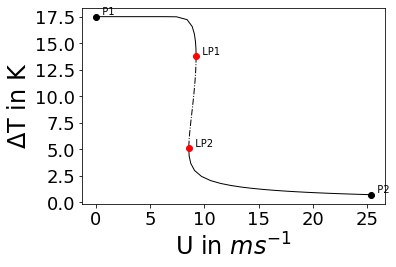

In [6]:
PC.newCurve(PCargs)
PC['EQ1'].forward()
PC.display(['U','x'], stability=True, figure=3)        # stable and unstable branches as solid and dashed curves, resp.
plt.title('')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.locator_params(axis="x", nbins=8)
plt.locator_params(axis="y", nbins=8)
plt.xlabel('U in $ms^{-1}$', fontsize = 24)
plt.ylabel('$\Delta$T in K', fontsize = 24)
plt.gcf().subplots_adjust(left=0.2, bottom =0.2)
#plt.savefig('bifurcation_diagram_shorttail_carbauw_l7_z03.png')

Typical S-shape of equilibrium solution branch, appears for all three stability functions. 
Histeresis-effect for small lumped parameter values: single stable equilibriumm for U < LP2 and single stable equilibrium for U >  LP2. For LP2 < U < LP1 two stable and one unstable equilibrium with a fast changing position.

### Information of the equilibrium curve:

In [7]:
PC['EQ1'].info()

PyCont curve EQ1 (type EP-C)
Using model: temperature inversion strength model

Model Info
---------- 

  Variables : w, x
  Parameters: q, l, U, rho, c_p, k, g, T_r, z_r, z_0, alpha

Continuation Parameters
----------------------- 

name  =  EQ1
auxpars  =  []
freepars  =  ['U']
MaxNumPoints  =  64
MaxCorrIters  =  5
MaxTestIters  =  10
MaxStepSize  =  1
MinStepSize  =  1e-05
StepSize  =  1
VarTol  =  1e-06
FuncTol  =  1e-06
TestTol  =  0.0001
LocBifPoints  =  ['LP']
verbosity  =  1
ClosedCurve  =  50
SaveJacobian  =  False
SaveEigen  =  True
Corrector  =  <bound method Continuation._MoorePenrose of PyCont curve EQ1 (type EP-C)>
UseAuto  =  False
StopAtPoints  =  []
SPOut  =  None


Special Points
-------------- 

P1, P2, LP1, LP2


### Information about the bifurcation points LP1 and LP2:

In [8]:
print(PC['EQ1'].getSpecialPoint('LP1')) 

U:  9.235093820662785
w:  13.772856279944103
x:  13.772856279944103
Labels: EP ({'data': args (
 V = {'w': -0.7071067811865476, 'x': -0.7071067811865476, 'U': -7.900116824581897e-09},
 ds = 1,
 evals = [-9.99999999e-01+0.j  1.87405647e-07+0.j],
 evecs = [[1.         0.70710671]
 [0.         0.70710685]]
), 'stab': 'N'})
Labels: LP ({'data': args (
 X = {'w': 13.772856279944103, 'x': 13.772856279944103, 'U': 9.235093820662785},
 V = {'w': -0.7071067811865476, 'x': -0.7071067811865476, 'U': -7.900116824581897e-09},
 a = 0.2829638960715554,
 eigs = [-9.99999999e-01+0.j  1.87405647e-07+0.j]
), 'plot': No args defined, 'name': 'LP1'})


In [9]:
print(PC['EQ1'].getSpecialPoint('LP2')) 

U:  8.559884689475465
w:  5.075380506807932
x:  5.075380506807932
Labels: EP ({'data': args (
 V = {'w': -0.7071067811865475, 'x': -0.7071067811865475, 'U': -1.1335724185687429e-08},
 ds = 1,
 evals = [-1.00000000e+00+0.j  3.58824082e-07+0.j],
 evecs = [[1.         0.70710665]
 [0.         0.70710691]]
), 'stab': 'N'})
Labels: LP ({'data': args (
 X = {'w': 5.075380506807932, 'x': 5.075380506807932, 'U': 8.559884689475465},
 V = {'w': -0.7071067811865475, 'x': -0.7071067811865475, 'U': -1.1335724185687429e-08},
 a = 0.8785131685039994,
 eigs = [-1.00000000e+00+0.j  3.58824082e-07+0.j]
), 'plot': No args defined, 'name': 'LP2'})


In [10]:
print(PC['EQ1'].getSpecialPoint('P1')) 

U:  0.01
w:  17.5
x:  17.5
Labels: EP ({'data': args (
 V = {'w': 0.0, 'x': 0.0, 'U': 1.0},
 ds = 0.02,
 evals = [-1.+0.j -4.+0.j],
 evecs = [[ 1.         -0.31622777]
 [ 0.          0.9486833 ]]
), 'stab': 'S'})
Labels: P ({'data': args (
 V = {'w': 0.0, 'x': 0.0, 'U': 1.0}
), 'plot': No args defined, 'name': 'P1'})


In [11]:
print(PC['EQ1'].getSpecialPoint('P2')) 

U:  25.396085022922737
w:  0.7201624754313021
x:  0.7201624754313021
Labels: EP ({'data': args (
 V = {'w': -0.028432400647587043, 'x': -0.028432400647587043, 'U': 0.9991912715725804},
 ds = 1,
 evals = [ -1.        +0.j -95.75643175+0.j],
 evecs = [[ 1.         -0.01055279]
 [ 0.          0.99994432]]
), 'stab': 'S'})
Labels: P ({'data': args (
 V = {'w': -0.028432400647587043, 'x': -0.028432400647587043, 'U': 0.9991912715725804}
), 'plot': No args defined, 'name': 'P2'})


### Change of the bifurcation points, when $\lambda$ varies:

CP Point found 


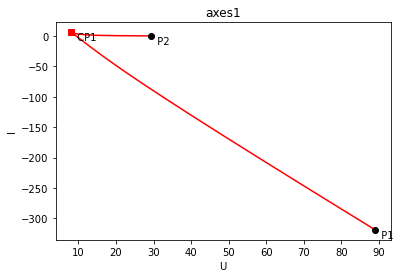

In [12]:
PCargs = dst.args(name='SN1', type='LP-C')
PCargs.initpoint    = 'EQ1:LP1'
PCargs.freepars     = ['U', 'l']
PCargs.MaxStepSize  = 2
PCargs.LocBifPoints = ['CP']
PCargs.MaxNumPoints = 200
PC.newCurve(PCargs)
PC['SN1'].forward()
PC['SN1'].backward()
PC['SN1'].display(['U','l'], figure=4)

CP Point found 


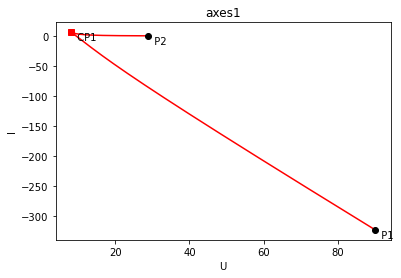

In [13]:
PCargs = dst.args(name='SN2', type='LP-C')
PCargs.initpoint    = 'EQ1:LP2'
PCargs.freepars     = ['U', 'l']
PCargs.MaxStepSize  = 2
PCargs.LocBifPoints = ['CP']
PCargs.MaxNumPoints = 200
PC.newCurve(PCargs)
PC['SN2'].forward()
PC['SN2'].backward()
PC['SN2'].display(['U','l'], figure=4)